In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from IPython.display import clear_output
from PIL import Image

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_PATH = '/kaggle/input/project/train.parquet'
TEST_PATH = '/kaggle/input/project/test.parquet'
TRAIN_IMAGES_PATH = '/kaggle/input/project/train/train'
TEST_IMAGES_PATH = '/kaggle/input/project/test/test'

In [3]:
test_columns = ['item_id', 'image_name']
train_columns = test_columns + ['real_weight', 'real_height', 'real_length', 'real_width']

In [4]:
data_train = pd.read_parquet(TRAIN_PATH, engine='pyarrow', columns=train_columns)
data_test = pd.read_parquet(TEST_PATH, engine='pyarrow', columns=test_columns)


In [5]:
heavy_weights = data_train.nlargest(100, 'real_weight')

highest = data_train.nlargest(100, 'real_height')

longest = data_train.nlargest(100, 'real_length')

widthest = data_train.nlargest(100, 'real_width')

indexes_to_drop = pd.concat([pd.Series(heavy_weights.index),
                             pd.Series(highest.index),
                             pd.Series(longest.index),
                             pd.Series(widthest.index)])

data_train = data_train.drop(indexes_to_drop)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data_train[['image_name', 'item_id']], 
    data_train[['real_weight', 'real_height', 'real_length', 'real_width']], 
    test_size=0.25, 
    random_state=42
)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dir_path, images, labels, to_train=True):
        self.dir_path = dir_path
        self.images = images
        self.labels = labels
        self.to_train = to_train
        
        self.train_transforms = transforms.Compose([
            transforms.Resize((528, 528)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomResizedCrop(528, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.val_transforms = transforms.Compose([
            transforms.Resize((528, 528)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        transformation = self.train_transforms if self.to_train else self.val_transforms
        label = np.array(self.labels.iloc[idx], dtype=np.float32)
        path = os.path.join(self.dir_path, self.images['image_name'].iloc[idx])
        image = Image.open(path).convert('RGB')
        image = transformation(image)
        return image, label
     
    

In [8]:
train_dataset = ImageDataset(
    TRAIN_IMAGES_PATH, 
    X_train, 
    y_train, 
    True
)

val_dataset = ImageDataset(
    TRAIN_IMAGES_PATH,
    X_test,
    y_test,
    False
)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers = 4)

In [10]:
class EfficientNetRegressor(nn.Module):
    def __init__(self, num_outputs=4):
        super().__init__()
        
        # Load pre-trained EfficientNet-B6
        self.backbone = models.efficientnet_b6(pretrained=True)
        
        # Get the number of input features to the classifier
        in_features = self.backbone.classifier[1].in_features  # 2304 for B6
        
        # Remove the original classifier
        self.backbone.classifier = nn.Identity()
        
        # Shared encoding layer
        self.shared_encoding = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 512),
            nn.LayerNorm(512),
            nn.GELU(),
        )
        
        # Regression head (only regression, no classification)
        self.regression_head = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, num_outputs)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.shared_encoding(x)
        predictions = self.regression_head(x)
        return predictions

    def get_embeddings(self, x):
        """Extract embeddings"""
        with torch.no_grad():
            x = self.backbone(x)
            return self.shared_encoding(x)

In [11]:
def plot_progress(lrs, train_losses, val_losses):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(15)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_losses, label='val loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(lrs, label='learning rate')
    ax2.set_title('Learning rate')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

def schedule(step_number, breaking_step1=100, breaking_step2=2000):
    if step_number < breaking_step1:
        return step_number / breaking_step1
    elif step_number < breaking_step2:
        return 1
    else:
        return (0.99 ** (step_number - breaking_step2))

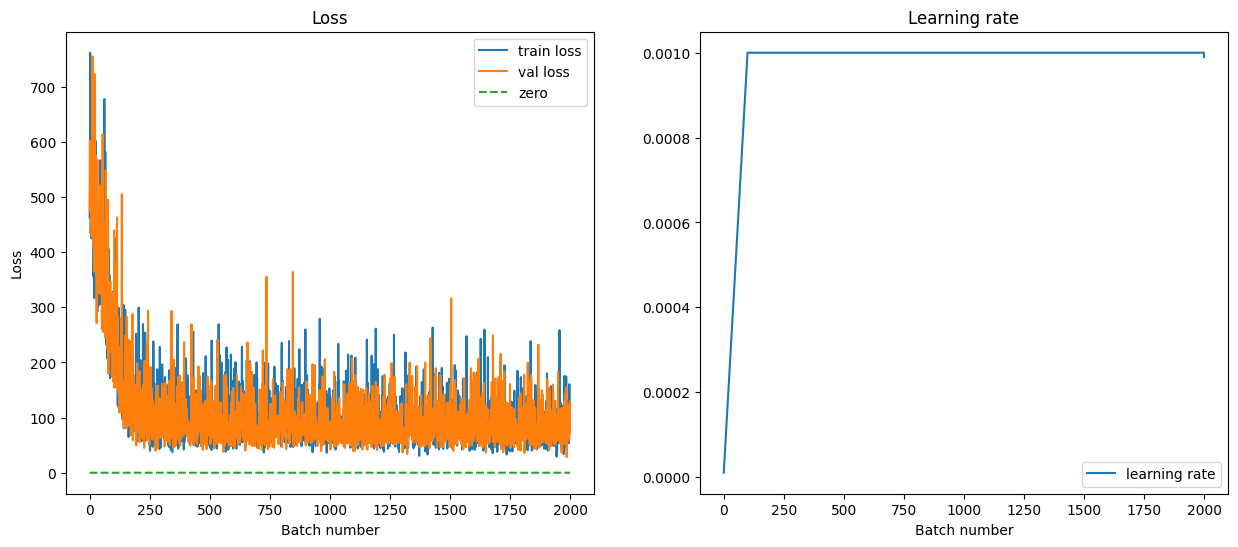

Saving model weights...


In [12]:
n_epochs = 1
model = EfficientNetRegressor(num_outputs=4)
model.to(DEVICE)

# Freeze backbone initially
for param in model.backbone.parameters():
    param.requires_grad = False

for param in model.shared_encoding.parameters():
    param.requires_grad = True
for param in model.regression_head.parameters():
    param.requires_grad = True

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
criterion = nn.MSELoss()

# Training
losses = []
val_losses = []
lrs = []

for epoch in range(n_epochs):
    model.train()
    
    for batch_idx, (x_train, y_train) in enumerate(train_dataloader):
        x_train = x_train.to(DEVICE)
        y_train = y_train.to(DEVICE)
        
        predictions = model(x_train)
        loss = criterion(predictions, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        lrs.append(optimizer.param_groups[0]["lr"])
        
        # Plot progress
        plot_progress(lrs, losses, val_losses)

        model.eval()
        
        for x_val, y_val in val_dataloader:
            x_val = x_val.to(DEVICE)
            y_val = y_val.to(DEVICE)
            
            predictions = model(x_val)
            val_loss = criterion(predictions, y_val)
            val_losses.append(val_loss.item())
    
            plot_progress(lrs, losses, val_losses)
            break
            
        if batch_idx == 2000:
            break
print('Saving model weights...')
torch.save(model.state_dict(), 'efficientnet_b6_weights.pth')

In [21]:
class TestImageDataset(Dataset):
    def __init__(self, dir_path, images, labels):
        self.dir_path = dir_path
        self.images = images
        self.labels = labels
        
        self.val_transforms = transforms.Compose([
            transforms.Resize((518, 518)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        transformation = self.val_transforms
            
        label = np.array(self.labels.iloc[idx])
        path = os.path.join(self.dir_path, self.images['image_name'].iloc[idx])
        image = Image.open(path).convert('RGB')
        image = transformation(image)
        
        item_id = self.images['item_id'].iloc[idx]
        
        return image, label, item_id


from tqdm import tqdm  # Импорт tqdm

def extract_embeddings(model, dataloader, device=DEVICE, save_path='embeddings.csv'):
    """
    Извлекает эмбеддинги для всего датасета и сохраняет в CSV
    
    Args:
        model: обученная модель
        dataloader: датасет для извлечения эмбеддингов
        device: устройство (cuda/cpu)
        save_path: путь для сохранения CSV файла
    
    Returns:
        DataFrame размером n×512 с item_id в качестве индекса
    """
    model.eval()
    
    all_embeddings = []
    all_item_ids = []
    
    with torch.no_grad():
        # Оборачиваем dataloader в tqdm для прогресс-бара
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Extracting embeddings")
        
        for batch_idx, batch_data in progress_bar:
            # Распаковываем данные (поддержка старого и нового формата)
            if len(batch_data) == 3:
                images, labels, item_ids = batch_data
            else:
                images, labels = batch_data
                # Если item_ids нет, генерируем их
                batch_size = images.size(0)
                start_idx = batch_idx * dataloader.batch_size
                item_ids = list(range(start_idx, start_idx + batch_size))
            
            images = images.to(device)
            
            # Получаем эмбеддинги [batch_size, 512]
            embeddings = model.get_embeddings(images)
            
            all_embeddings.append(embeddings.cpu().numpy())
            
            # Сохраняем item_ids
            if isinstance(item_ids, torch.Tensor):
                all_item_ids.extend(item_ids.cpu().numpy().tolist())
            else:
                all_item_ids.extend(item_ids)
    
    # Объединяем все батчи
    embeddings_array = np.vstack(all_embeddings)  # [N, 512]
    
    # Создаем DataFrame с эмбеддингами
    embedding_columns = [f'emb_{i}' for i in range(embeddings_array.shape[1])]
    df_embeddings = pd.DataFrame(embeddings_array, columns=embedding_columns)
    
    # Устанавливаем item_id как индекс
    df_embeddings.index = all_item_ids
    df_embeddings.index.name = 'item_id'
    
    # Сохраняем в CSV (с индексом)
    print(f"Saving embeddings to {save_path}...")
    df_embeddings.to_csv(save_path, index=True)
    
    print(f"DataFrame shape: {df_embeddings.shape}")
    print(f"Index (item_id) range: {df_embeddings.index.min()} - {df_embeddings.index.max()}")
    
    return df_embeddings

In [22]:
train_dataset_emb = TestImageDataset(
    TRAIN_IMAGES_PATH, 
    data_train[['item_id', 'image_name']], 
    data_train[['real_weight', 'real_height', 'real_length', 'real_width']]
)

train_dataloader_emb = DataLoader(
    train_dataset_emb,
    batch_size=32, 
    shuffle=False, 
    num_workers = 4
)

train_embeddings_df = extract_embeddings(
    model=model,
    dataloader=train_dataloader_emb,
    device=DEVICE,
    save_path='image_embeddings/train_embeddings.csv'
)


Extracting embeddings: 100%|██████████| 9768/9768 [3:44:45<00:00,  1.38s/it]  


Saving embeddings to test_embeddings.csv...
DataFrame shape: (312561, 512)
Index (item_id) range: 4 - 2107277


In [25]:
train_embeddings_df

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
item_id,,,,,,,,,,,,,,,,,,,,,
185689,-0.156767,0.937978,-0.130610,-0.159742,1.137382,-0.092890,-0.132252,-0.165468,-0.144291,-0.030372,...,-0.072296,-0.153267,-0.148523,0.103790,-0.150219,-0.086647,2.711386,-0.080418,-0.122834,0.026617
1914373,-0.128701,1.598926,-0.097801,-0.123991,-0.140188,1.191739,-0.122693,0.003990,-0.009183,-0.120912,...,-0.064116,0.646297,0.040887,0.064200,0.066731,-0.111893,-0.109402,-0.122046,0.057350,-0.161379
361626,-0.076177,-0.086823,-0.004748,-0.052027,0.175857,-0.168115,0.528685,-0.106847,-0.120260,-0.133280,...,0.158010,-0.169960,-0.016909,-0.002961,0.051580,-0.169971,2.121208,0.226266,-0.141125,-0.124685
534927,-0.101193,1.173661,0.026550,-0.002307,0.361756,-0.147644,0.247760,0.001711,-0.086077,-0.160310,...,0.198989,-0.059321,-0.037848,-0.084351,0.305937,-0.047512,0.370500,0.446710,-0.161645,-0.052815
199043,-0.035099,0.748052,0.091676,0.067099,-0.136315,-0.089114,-0.144762,0.036621,0.193511,-0.134021,...,0.012000,0.854087,-0.074127,0.189009,0.015897,-0.071736,-0.167306,-0.047949,-0.108716,0.175488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156951,-0.159587,-0.127923,-0.140941,-0.065200,0.906674,1.084395,0.388822,-0.100538,-0.136824,-0.167732,...,-0.088657,-0.169887,0.263927,-0.120384,0.013832,-0.168667,2.758991,-0.164055,-0.106156,-0.114687
2095493,-0.155614,1.087302,0.023640,0.212127,-0.160908,-0.053017,-0.105833,-0.169682,-0.142179,-0.053565,...,-0.114993,-0.021043,-0.163085,0.271863,-0.165216,-0.169740,-0.041323,1.183119,-0.169338,1.138641
218757,-0.158324,1.509262,0.033875,0.258804,0.242746,-0.147697,-0.118775,-0.113077,0.109718,-0.089834,...,-0.034803,-0.169895,-0.005601,0.070354,0.114610,-0.169081,-0.166339,-0.092517,-0.134014,0.076930


In [26]:
class ValImageDataset(Dataset):
    def __init__(self, dir_path, images):
        self.dir_path = dir_path
        self.images = images
        
        self.val_transforms = transforms.Compose([
            transforms.Resize((518, 518)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        transformation = self.val_transforms
            
        path = os.path.join(self.dir_path, self.images['image_name'].iloc[idx])
        image = Image.open(path).convert('RGB')
        image = transformation(image)
        
        item_id = self.images['item_id'].iloc[idx]
        
        return image, item_id

def val_extract_embeddings(model, dataloader, device=DEVICE, save_path='embeddings.csv'):
    """
    Извлекает эмбеддинги для всего датасета и сохраняет в CSV
    
    Args:
        model: обученная модель
        dataloader: датасет для извлечения эмбеддингов
        device: устройство (cuda/cpu)
        save_path: путь для сохранения CSV файла
    
    Returns:
        DataFrame размером n×512 с item_id в качестве индекса
    """
    model.eval()
    
    all_embeddings = []
    all_item_ids = []
    
    with torch.no_grad():
        # Оборачиваем dataloader в tqdm для прогресс-бара
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Extracting embeddings")
        
        for batch_idx, (images, item_ids) in progress_bar:
            images = images.to(device)
            
            # Получаем эмбеддинги [batch_size, 512]
            embeddings = model.get_embeddings(images)
            
            all_embeddings.append(embeddings.cpu().numpy())
            
            # Сохраняем item_ids
            if isinstance(item_ids, torch.Tensor):
                all_item_ids.extend(item_ids.cpu().numpy().tolist())
            else:
                all_item_ids.extend(item_ids)
    
    # Объединяем все батчи
    embeddings_array = np.vstack(all_embeddings)  # [N, 512]
    
    # Создаем DataFrame с эмбеддингами
    embedding_columns = [f'emb_{i}' for i in range(embeddings_array.shape[1])]
    df_embeddings = pd.DataFrame(embeddings_array, columns=embedding_columns)
    
    # Устанавливаем item_id как индекс
    df_embeddings.index = all_item_ids
    df_embeddings.index.name = 'item_id'
    
    # Сохраняем в CSV (с индексом)
    print(f"Saving embeddings to {save_path}...")
    df_embeddings.to_csv(save_path, index=True)
    
    print(f"DataFrame shape: {df_embeddings.shape}")
    print(f"Index (item_id) range: {df_embeddings.index.min()} - {df_embeddings.index.max()}")
    
    return df_embeddings

In [27]:
val_dataset_emb = ValImageDataset(
    TEST_IMAGES_PATH, 
    data_test[['item_id', 'image_name']]
)

val_dataloader_emb = DataLoader(
    val_dataset_emb,
    batch_size=32, 
    shuffle=False, 
    num_workers = 4
)

val_embeddings_df = extract_embeddings(
    model=model,
    dataloader=val_dataloader_emb,
    device=DEVICE,
    save_path='image_embeddings/test_embeddings.csv'
)

Extracting embeddings: 100%|██████████| 2197/2197 [50:27<00:00,  1.38s/it]


Saving embeddings to val_embeddings.csv...
DataFrame shape: (70274, 512)
Index (item_id) range: 0 - 70273
